In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy import interpolate, ndimage
from sklearn import gaussian_process, metrics

# Data Preparation

## Functions

In [111]:
# Smooth function
def fun_smooth(x, y):
    return np.cos(np.pi * x) * np.sin(np.pi * y)

In [112]:
# Evil function(non-continuous)
def fun_evil(x, y):
    # watch out for singular origin; function has no unique limit there
    return np.where(x ** 2 + y ** 2 > 1e-10, x * y / (x ** 2 + y ** 2), 0.5)

## Dataset

### Train Dataset

In [113]:
# define min and max value
val_min, val_max = -1, 1

In [114]:
n_train = 100
n_random = 10
y_offset = 1
# x_train = np.linspace(val_min, val_max, n_train)
x_train = np.sort(
    np.random.choice(np.linspace(val_min, val_max, n_train), n_random, replace=False)
)
# produce an asymmetric shape by adding y_offset in order to catch issues with transpositions
# y_train = np.linspace(val_min, val_max, int(n_train * (1 + y_offset)))
y_train = np.sort(
    np.random.choice(
        np.linspace(val_min, val_max, n_train), n_random + y_offset, replace=False
    )
)

In [115]:
z_train_smooth = fun_smooth(x_train, y_train[:n_random])
z_train_evil = fun_evil(x_train, y_train[:n_random])

In [116]:
# convert x, y data into meshgrid data
x_train_grid, y_train_grid = np.meshgrid(x_train, y_train)

In [117]:
# calculate z value
z_train_grid_smooth = fun_smooth(x_train_grid, y_train_grid)
z_train_grid_evil = fun_evil(x_train_grid, y_train_grid)

In [118]:
print(
    x_train.shape,
    y_train.shape,
    x_train_grid.shape,
    y_train_grid.shape,
    z_train_grid_smooth.shape,
    z_train_grid_evil.shape,
)

(10,) (11,) (11, 10) (11, 10) (11, 10) (11, 10)


In [119]:
points = np.c_[x_train_grid.flatten(), y_train_grid.flatten()]
values_smooth = z_train_grid_smooth.flatten()
values_evil = z_train_grid_evil.flatten()

### Interpolate Dataset

In [120]:
N_inter = 100
# 2D grid for interpolation
X_inter = np.linspace(min(x_train), max(x_train), N_inter)
Y_inter = np.linspace(min(y_train), max(y_train), N_inter + y_offset)
X_inter_grid, Y_inter_grid = np.meshgrid(X_inter, Y_inter)

In [121]:
print(X_inter.shape, Y_inter.shape, X_inter_grid.shape, Y_inter_grid.shape)

(100,) (101,) (101, 100) (101, 100)


In [122]:
pts_inter = np.c_[X_inter_grid.flatten(), Y_inter_grid.flatten()]

In [123]:
# Z_grid_smooth = fun_smooth(X_inter_grid.flatten(), Y_inter_grid.flatten()).reshape(X_inter_grid.shape)
Z_grid_smooth = fun_smooth(pts_inter[:, 0], pts_inter[:, 1]).reshape(X_inter_grid.shape)

In [124]:
# Z_grid_evil = fun_evil(X_inter_grid.flatten(), Y_inter_grid.flatten()).reshape(X_inter_grid.shape)
Z_grid_evil = fun_evil(pts_inter[:, 0], pts_inter[:, 1]).reshape(X_inter_grid.shape)

## Visulize Dataset

### Train Dataset

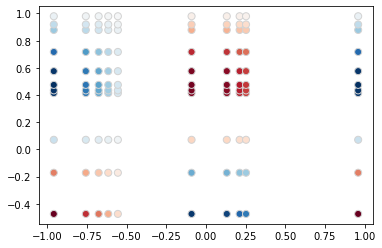

In [125]:
_, ax = plt.subplots()
# ax.pcolormesh(
#     X_inter_grid,
#     Y_inter_grid,
#     Z_grid_smooth,
#     shading="auto",
#     cmap="RdBu_r",
# )

ax.scatter(
    x_train_grid.flat,
    y_train_grid.flat,
    ec="lightgray",
    s=50,
    c=z_train_grid_smooth.flat,
    cmap="RdBu_r",
)

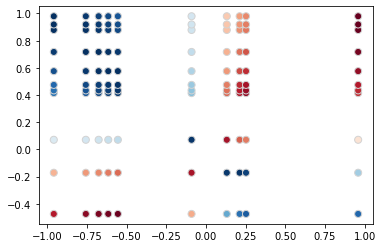

In [126]:
_, ax = plt.subplots()
# ax.pcolormesh(X_inter_grid, Y_inter_grid, Z_grid_evil, shading="auto", cmap="RdBu_r")

ax.scatter(
    x_train_grid.flat,
    y_train_grid.flat,
    ec="lightgray",
    s=50,
    c=z_train_grid_evil.flat,
    cmap="RdBu_r",
)

### Interpolate Dataset

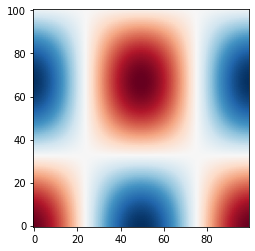

In [127]:
plt.imshow(Z_grid_smooth, cmap="RdBu_r", origin="lower")

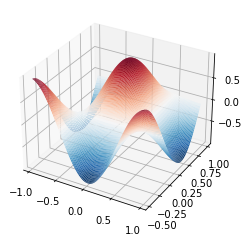

In [128]:
ax = plt.subplot(111, projection="3d")
ax.plot_surface(
    X_inter_grid, Y_inter_grid, Z_grid_smooth, rstride=1, cstride=1, cmap="RdBu_r"
)
plt.show()

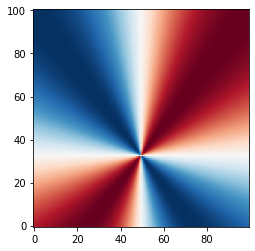

In [129]:
plt.imshow(Z_grid_evil, cmap="RdBu_r", origin="lower")

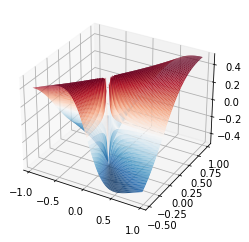

In [130]:
ax = plt.subplot(111, projection="3d")
ax.plot_surface(
    X_inter_grid, Y_inter_grid, Z_grid_evil, rstride=1, cstride=1, cmap="RdBu_r"
)
plt.show()

# Multivariate interpolation Methods
[scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html)

In [131]:
# Interpolation Method
M = "cubic"

## Unstructured data

### Rbf(radial basis function)
[scipy.interpolate.Rbf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html)
___
`args`: arrays  
x, y, z, …, d, where x, y, z, … are the coordinates of the nodes and d is the array of values at the nodes

`function`: str or callable, optional  
The radial basis function, based on the radius, r, given by the norm (default is Euclidean distance);
the default is ‘multiquadric’
>'multiquadric': sqrt((r/self.epsilon)**2 + 1)  
>'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)  
>'gaussian': exp(-(r/self.epsilon)**2)  
>'linear': r  
>'cubic': r**3  
>'quintic': r**5  
>'thin_plate': r**2 * log(r)
---
`Summary`
* Rbf needs to invert n x n matrix, which turns out to be impossible if data points n > 5000
* produces well-behaved output even for crazy input data
* supports interpolation in higher dimensions
* extrapolates outside the convex hull of the input points
* creates an interpolator as a first step, so evaluating it in various output points is less additional effort
* prone to preserving the symmetry of the input data
* supports multiple kinds of radial functions for keyword function

In [132]:
# both input and output points were 2d arrays
model = M
interp_rbf_smooth = interpolate.Rbf(
    x_train_grid, y_train_grid, z_train_grid_smooth, function=model, smooth=0
)
Z_inter_grid_smooth = interp_rbf_smooth(X_inter_grid, Y_inter_grid)

In [133]:
# model = M
# interp_rbf_smooth = interpolate.Rbf(
#     x_train, y_train[:n_random], z_train_smooth, function=model, smooth=0
# )
# Z_inter_grid_smooth = interp_rbf_smooth(X_inter_grid, Y_inter_grid)

In [134]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_smooth, Z_inter_grid_smooth, squared=False)
print(rmse)

0.02926505626553135


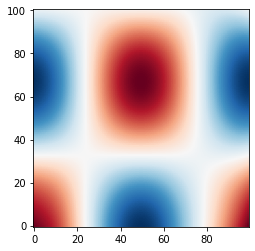

In [135]:
plt.imshow(Z_inter_grid_smooth, cmap="RdBu_r", origin="lower")

In [136]:
model = M
interp_rbf_evil = interpolate.Rbf(
    x_train_grid, y_train_grid, z_train_grid_evil, function=model, smooth=0
)
Z_inter_grid_evil = interp_rbf_evil(X_inter_grid, Y_inter_grid)

In [137]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_evil, Z_inter_grid_evil, squared=False)
print(rmse)

0.042673896443886396


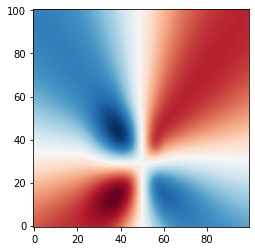

In [138]:
plt.imshow(Z_inter_grid_evil, cmap="RdBu_r", origin="lower")

### griddata
[scipy.interpolate.griddata](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html)
___
`points`: 2-D ndarray of floats with shape (n, D), or length D tuple of 1-D ndarrays with shape (n,).  
Data point coordinates.

`values`: ndarray of float or complex, shape (n,)  
Data values.  

`xi`: 2-D ndarray of floats with shape (m, D), or length D tuple of ndarrays broadcastable to the same shape.  
Points at which to interpolate data.  

`method`: Method of interpolation. One of    
> *nearest*: return the value at the data point closest to the point of interpolation.  
> *linear*: tessellate the input point set to N-D simplices, and interpolate linearly on each simplex.  
> *cubic 1d*: return the value determined from a cubic spline.  
> *cubic 2d*: return the value determined from a piecewise cubic, continuously differentiable (C1), and approximately curvature-minimizing polynomial surface.  
---
`Summary`
* produces well-behaved output even for crazy input data
* supports interpolation in higher dimensions
* does not perform extrapolation, a single value can be set for the output outside the convex hull of the input points (see fill_value)
* computes the interpolated values in a single call, so probing multiple sets of output points starts from scratch
* linear interpolation use `NearestNDInterpolator` and `LinearNDInterpolator` under the hood
* cubic-1d interpolation uses a spline and cubic-2d interpolation uses `CloughTocher2DInterpolator`
* might violate the symmetry of the input data

In [139]:
model = M
Z_inter_grid_smooth = interpolate.griddata(
    points, values_smooth, (X_inter_grid, Y_inter_grid), method=model
)

In [140]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_smooth, Z_inter_grid_smooth, squared=False)
print(rmse)

0.04897435677446764


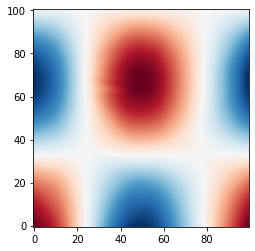

In [141]:
plt.imshow(Z_inter_grid_smooth, cmap="RdBu_r", origin="lower")

In [142]:
model = M
Z_inter_grid_evil = interpolate.griddata(
    points, values_evil, (X_inter_grid, Y_inter_grid), method=model
)

In [143]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_evil, Z_inter_grid_evil, squared=False)
print(rmse)

0.052401137635634504


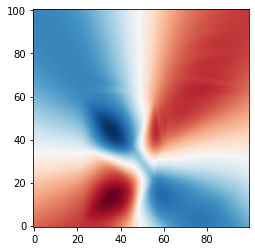

In [144]:
plt.imshow(Z_inter_grid_evil, cmap="RdBu_r", origin="lower")

### interp2d
[scipy.interpolate.interp2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html)
___
`interp2d` is similar to Rbf in that it first needs constructing an interpolation instance, which can be called to provide the actual interpolated values.  
However, the output points have to be located on a rectangular mesh, so inputs going into the call to the interpolator have to be 1d vectors which span the output grid.  

`x`, `y` and `z` are arrays of values used to approximate some function f: z = f(x, y).  
This class returns a function whose call method uses spline interpolation to find the value of new points.  

`kind`: {‘linear’, ‘cubic’, ‘quintic’}, The kind of spline interpolation to use. Default is ‘linear’.   
It turns out that interp2d is a wrapper for the lower-level functions `bisplrep` + `bisplev`, the routines underlying interp2d are not really meant to perform interpolation.

---
`Summary`
* can lead to artifacts even with well-tempered data
* is specifically for bivariate problems
* performs extrapolation
* creates an interpolator as a first step, so evaluating it in various output points is less additional effort
* can only produce output over a rectangular grid, for scattered output you would have to call the interpolator in a loop
* might violate the symmetry of the input data

In [145]:
model = M
interp_2d_smooth = interpolate.interp2d(
    x_train_grid, y_train_grid, z_train_grid_smooth, kind=model
)
Z_inter_grid_smooth = interp_2d_smooth(X_inter, Y_inter)

D:\ProgramData\Anaconda3\envs\env_py38\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=13,17 m=110 fp=0.000003 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [146]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_smooth, Z_inter_grid_smooth, squared=False)
print(rmse)

0.10162821842174612


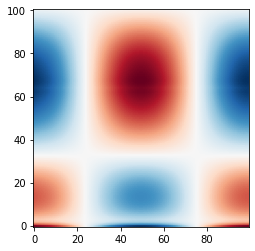

In [147]:
plt.imshow(Z_inter_grid_smooth, cmap="RdBu_r", origin="lower")

In [148]:
model = M
interp_2d_evil = interpolate.interp2d(
    x_train_grid, y_train_grid, z_train_grid_evil, kind=model
)
Z_inter_grid_evil = interp_2d_evil(X_inter, Y_inter)

In [149]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_evil, Z_inter_grid_evil, squared=False)
print(rmse)

0.14315328056186055


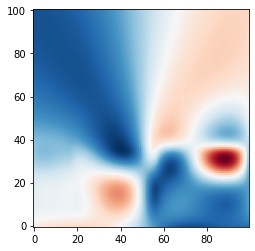

In [150]:
plt.imshow(Z_inter_grid_evil, cmap="RdBu_r", origin="lower")

### LinearNDInterpolator
[scipy.interpolate.LinearNDInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html)
___
Piecewise linear interpolant in N dimensions.  
The interpolant is constructed by triangulating the input data with Qhull, and on each triangle performing linear barycentric interpolation.  

`points`: ndarray of floats, shape (npoints, ndims); or Delaunay.  
Data point coordinates, or a precomputed Delaunay triangulation.

`values`: ndarray of float or complex, shape (npoints, …)  
Data values.  

---
`Summary`
* xxx

In [151]:
interp_LND_smooth = interpolate.LinearNDInterpolator(points, values_smooth)
Z_inter_grid_smooth = interp_LND_smooth(X_inter_grid, Y_inter_grid)

In [152]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_smooth, Z_inter_grid_smooth, squared=False)
print(rmse)

0.09851186501698617


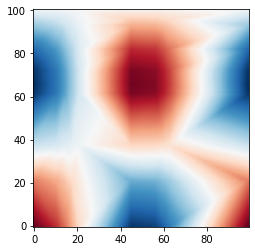

In [153]:
plt.imshow(Z_inter_grid_smooth, cmap="RdBu_r", origin="lower")

In [154]:
interp_LND_evil = interpolate.LinearNDInterpolator(points, values_evil)
Z_inter_grid_evil = interp_LND_evil(X_inter_grid, Y_inter_grid)

In [155]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_evil, Z_inter_grid_evil, squared=False)
print(rmse)

0.06339726577116328


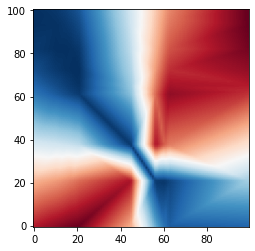

In [156]:
plt.imshow(Z_inter_grid_evil, cmap="RdBu_r", origin="lower")

## Regular Grid Data

### RectBivariateSpline
[scipy.interpolate.RectBivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html)
___
Bivariate spline approximation over a rectangular mesh. Can be used for both smoothing and interpolating data.  

`x, y`: 1-D arrays of coordinates in strictly ascending order.

`z`: 2-D array of data with shape (x.size,y.size).  

---
`Summary`
* xxx

In [157]:
interp_rbs_smooth = interpolate.RectBivariateSpline(
    x_train, y_train, z_train_grid_smooth.T
)
Z_inter_grid_smooth = interp_rbs_smooth(X_inter, Y_inter).T

In [158]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_smooth, Z_inter_grid_smooth, squared=False)
print(rmse)

0.004076737416324346


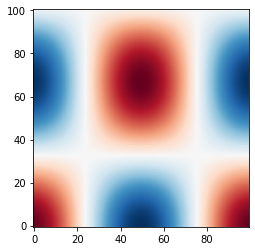

In [159]:
plt.imshow(Z_inter_grid_smooth, cmap="RdBu_r", origin="lower")

In [160]:
interp_rbs_evil = interpolate.RectBivariateSpline(x_train, y_train, z_train_grid_evil.T)
Z_inter_grid_evil = interp_rbs_evil(X_inter, Y_inter).T

In [161]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_evil, Z_inter_grid_evil, squared=False)
print(rmse)

0.1684264268059911


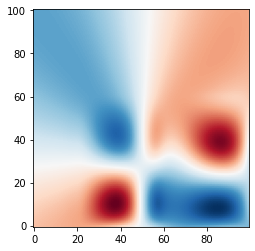

In [162]:
plt.imshow(Z_inter_grid_evil, cmap="RdBu_r", origin="lower")

### map_coordinates
[scipy.ndimage.map_coordinates](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html)
___
* Map the input array to new pixel coordinates by interpolation.
* The array of coordinates is used to find, for each point in the output, the corresponding coordinates in the input.  
* The value of the input at those coordinates is determined by spline interpolation of the requested order.  
* The shape of the output is derived from that of the coordinate array by dropping the first axis.  
* The values of the array along the first axis are the coordinates in the input array at which the output value is found.   

`input`: The input array is the train values with shape (x.size, y.size).

`coordinates`: The coordinates at which input is evaluated.  

`order`: The order of the spline interpolation, default is 3. The order has to be in the range 0-5.  

---
`Summary`
* xxx

In [163]:
# the fomular to calculate coords:
# (X_inter_grid - min(x_train))/(max(x_train)-min(x_train))*(len(x_train)-1)
# when X_inter_grid already belongs to [0, 1], and len(x_train)=n
# simplify the fomular as X_inter_grid*(n-1)
# method-1
coords_X = (X_inter_grid.flatten() - val_min) / (val_max - val_min) * (len(x_train) - 1)
coords_Y = (Y_inter_grid.flatten() - val_min) / (val_max - val_min) * (len(y_train) - 1)
coords = np.c_[coords_Y, coords_X].T

In [164]:
# method-2
coords = (
    (pts_inter - val_min)
    / (val_max - val_min)
    * np.array([[len(x_train) - 1, len(y_train) - 1]])
)[:, ::-1].T

In [165]:
Z_inter_grid_smooth = ndimage.map_coordinates(
    z_train_grid_smooth, coords, order=2
).reshape(X_inter_grid.shape)

In [166]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_smooth, Z_inter_grid_smooth, squared=False)
print(rmse)

0.7028694959795534


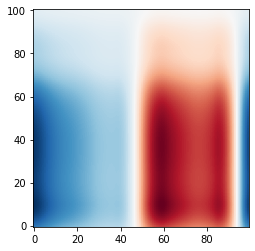

In [167]:
plt.imshow(Z_inter_grid_smooth, cmap="RdBu_r", origin="lower")

In [168]:
Z_inter_grid_evil = ndimage.map_coordinates(
    z_train_grid_evil, coords, order=2
).reshape(X_inter_grid.shape)

In [169]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_evil, Z_inter_grid_evil, squared=False)
print(rmse)

0.44181676067809533


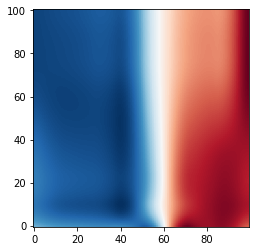

In [170]:
plt.imshow(Z_inter_grid_evil, cmap="RdBu_r", origin="lower")

### RegularGridInterpolator
[scipy.interpolate.RegularGridInterpolator](http://scipy.github.io/devdocs/generated/scipy.interpolate.RegularGridInterpolator.html)
___
Interpolation on a regular grid in arbitrary dimensions.  
The data must be defined on a regular grid, the grid spacing however may be uneven.  
Linear and nearest-neighbor interpolation are supported.    

`points`: tuple of ndarray of float, with shapes (m1, ), …, (mn, ). The points defining the regular grid in n dimensions.

`values`: array_like, shape (m1, …, mn, …). The data on the regular grid in n dimensions.  

`method`: The method of interpolation to perform. Supported are “linear” and “nearest”. Default is “linear”.  

---
`Summary`
* xxx

In [171]:
interp_RGI_smooth = interpolate.RegularGridInterpolator(
    (x_train, y_train), z_train_grid_smooth.T
)
Z_inter_grid_smooth = interp_RGI_smooth(pts_inter).reshape(X_inter_grid.shape)

In [172]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_smooth, Z_inter_grid_smooth, squared=False)
print(rmse)

0.07324602030565289


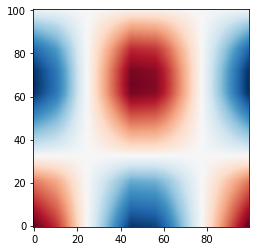

In [173]:
plt.imshow(Z_inter_grid_smooth, cmap="RdBu_r", origin="lower")

In [174]:
interp_RGI_evil = interpolate.RegularGridInterpolator(
    (x_train, y_train), z_train_grid_evil.T
)
Z_inter_grid_evil = interp_RGI_evil(pts_inter).reshape(X_inter_grid.shape)

In [175]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_evil, Z_inter_grid_evil, squared=False)
print(rmse)

0.06580427290378289


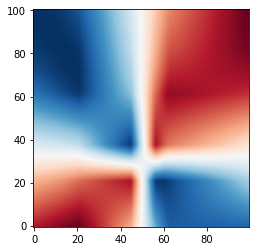

In [176]:
plt.imshow(Z_inter_grid_evil, cmap="RdBu_r", origin="lower")

## GaussianProcessRegressor
[sklearn.gaussian_process.GaussianProcessRegressor](https://scikit-learn.org/stable/modules/gaussian_process.html)
___
The hyperparameters of the kernel are optimized during fitting of GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) based on the passed `optimizer`.    
The noise level in the targets can be specified by passing it via the parameter `alpha`, either globally as a scalar or per datapoint.  

`kernel`: kernel instance, default=None. The kernel specifying the covariance function of the GP.   
If None is passed, the kernel `ConstantKernel(1.0, constant_value_bounds="fixed" * RBF(1.0, length_scale_bounds="fixed")` is used as default.   

`alpha`: float or ndarray of shape (n_samples,), default=1e-10. Value added to the diagonal of the kernel matrix during fitting.  
This can prevent a potential numerical issue during fitting, by ensuring that the calculated values form a positive definite matrix.  

`normalize_y`: bool, default=False. Whether the target values y are normalized, the mean and variance of the target values are set equal to 0 and 1 respectively.  
This is recommended for cases where zero-mean, unit-variance priors are used.  

---
`Summary`
* xxx

In [177]:
kernel1 = (
    gaussian_process.kernels.ConstantKernel()
    + gaussian_process.kernels.Matern()
    + gaussian_process.kernels.WhiteKernel()
)

In [178]:
kernel2 = (
    gaussian_process.kernels.ConstantKernel()
    + gaussian_process.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))
    #     + gaussian_process.kernels.WhiteKernel(
    #         noise_level=1e-5, noise_level_bounds=(1e-10, 1e1)
    #     )
)

In [179]:
interp_GPR_smooth = gaussian_process.GaussianProcessRegressor(
    kernel=kernel2, normalize_y=True
).fit(points, values_smooth)
print(interp_GPR_smooth.kernel_)
Z_inter_grid_smooth = interp_GPR_smooth.predict(pts_inter).reshape(X_inter_grid.shape)

0.00406**2 + RBF(length_scale=0.58)


D:\ProgramData\Anaconda3\envs\env_py38\lib\site-packages\sklearn\gaussian_process\_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [180]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_smooth, Z_inter_grid_smooth, squared=False)
print(rmse)

0.0009816861330583077


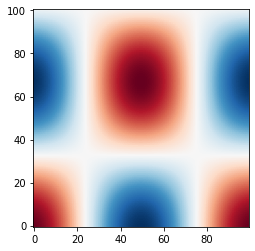

In [181]:
plt.imshow(Z_inter_grid_smooth, cmap="RdBu_r", origin="lower")

In [182]:
interp_GPR_evil = gaussian_process.GaussianProcessRegressor(
    kernel=kernel1, normalize_y=True
).fit(points, values_evil)
print(interp_GPR_evil.kernel_)
Z_inter_grid_evil = interp_GPR_evil.predict(pts_inter).reshape(X_inter_grid.shape)

0.00316**2 + Matern(length_scale=0.525, nu=1.5) + WhiteKernel(noise_level=1e-05)


D:\ProgramData\Anaconda3\envs\env_py38\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\ProgramData\Anaconda3\envs\env_py38\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [183]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(Z_grid_evil, Z_inter_grid_evil, squared=False)
print(rmse)

0.04044091893235227


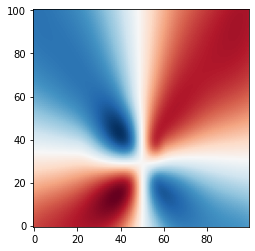

In [184]:
plt.imshow(Z_inter_grid_evil, cmap="RdBu_r", origin="lower")

## GPR Applicaton

In [185]:
# read data
# data_grid_path = 'data/result_grid_query.csv'
data_grid_path = 'data/sample_all_v2.csv'
data_grid_raw = pd.read_csv(data_grid_path)

In [186]:
# convert to gdf with utm coordinates
Helsinki_utm = 32635
data_grid_utm = gpd.GeoDataFrame(data_grid_raw,
                                 geometry=gpd.points_from_xy(data_grid_raw.Longitude,
                                                             data_grid_raw.Latitude),
                                 crs=4326
                                 ).to_crs(Helsinki_utm)
data_grid_utm[['Longitude_utm', 'Latitude_utm']] = np.c_[data_grid_utm.geometry.x, data_grid_utm.geometry.y]

In [188]:
data_grid_utm.columns

Index(['Longitude', 'Latitude', 'operator_name', 'avg_dl_4g_ios',
       'avg_dl_4g_ad', 'avg_dl_ip12_5g', 'avg_dl_ad_5g', 'avg_dl_4g_ios_pred',
       'avg_dl_4g_ad_pred', 'avg_dl_ip12_5g_pred', 'avg_dl_ad_5g_pred',
       'geometry', 'Longitude_utm', 'Latitude_utm'],
      dtype='object')

In [198]:
# 
# points_train = data_grid_utm.query('operator_name == "DNA" and network_type == "4G"')[['Longitude_utm', 'Latitude_utm', 'mid_dl']].values
points_train = data_grid_utm.query('operator_name == "DNA"')[['Longitude_utm', 'Latitude_utm', 'avg_dl_4g_ios']].dropna().values
points_inter = data_grid_utm.drop_duplicates(['Longitude_utm', 'Latitude_utm'])[['Longitude_utm', 'Latitude_utm']].values
print(points_train.shape, points_inter.shape)

(3135, 3) (7407, 2)


In [199]:
def remove_outlier(dataset, value_col, std_threshold):
    val = dataset[:, value_col]
    # calculate summary statistics
    val_mean, val_std = np.mean(val), np.std(val)
    # identify outliers
    val_cut_off = val_std * std_threshold
    val_lower = max(val.min(), val_mean - val_cut_off)
    val_upper = min(val.max(), val_mean + val_cut_off)
    # identify outliers
    non_outliers = np.where((val > val_lower) & (val < val_upper))[0]
    return dataset.copy()[non_outliers, :]

In [200]:
# remove outlier values
points_train = remove_outlier(dataset=points_train, value_col=2, std_threshold=2)
print(points_train.shape)

(2999, 3)


In [201]:
# normalize points coordinates
xy_min, xy_max = np.min(points_inter, axis=0), np.max(points_inter, axis=0)
points_train_norm = (points_train[:, :2] - xy_min)/(xy_max - xy_min)
points_inter_norm = (points_inter - xy_min)/(xy_max - xy_min)

In [202]:
# distance 500m
1000/(xy_max - xy_min)

array([0.02410187, 0.02995731])

In [203]:
# value
val_train = points_train[:, 2]

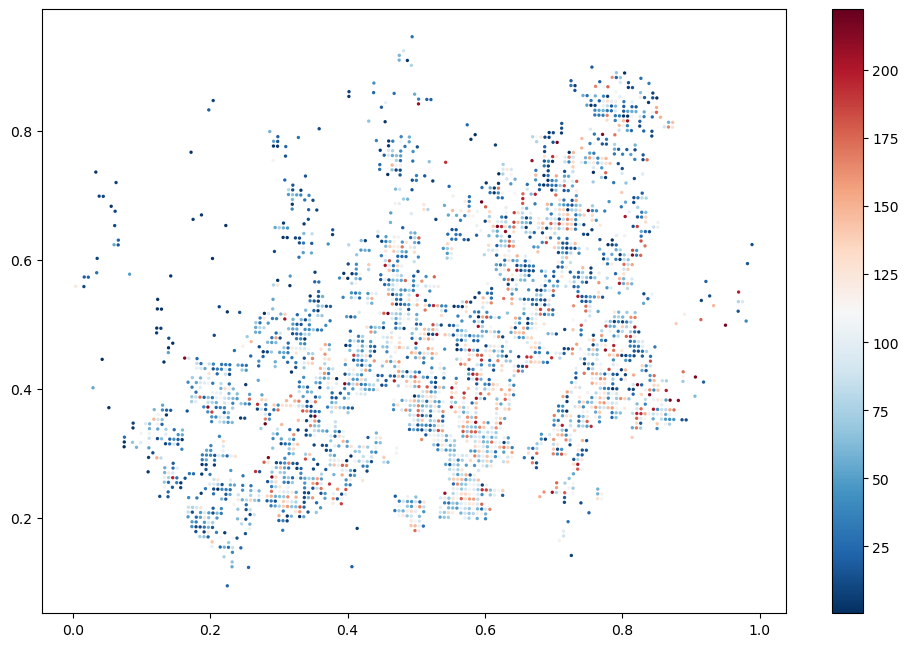

In [227]:
# plot train dataset
plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(points_train_norm[:, 0], points_train_norm[:, 1], s=2, c=val_train, cmap="RdBu_r")
plt.colorbar()
plt.show()

In [206]:
kernel = (
    gaussian_process.kernels.ConstantKernel(
        constant_value=1e-5, constant_value_bounds=(1e-10, 1e1)
    )
    + gaussian_process.kernels.Matern(
        length_scale=1000/(xy_max - xy_min),
        nu=0.5,
        length_scale_bounds="fixed",
    )
    + gaussian_process.kernels.WhiteKernel(
        noise_level=1e-5, noise_level_bounds=(1e-10, 1e1)
    )
)

In [207]:
# GRP model
interp_GPR = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y=True).fit(points_train_norm, val_train)
print(interp_GPR.kernel_)

0.00363**2 + Matern(length_scale=[0.0241, 0.03], nu=0.5) + WhiteKernel(noise_level=0.53)


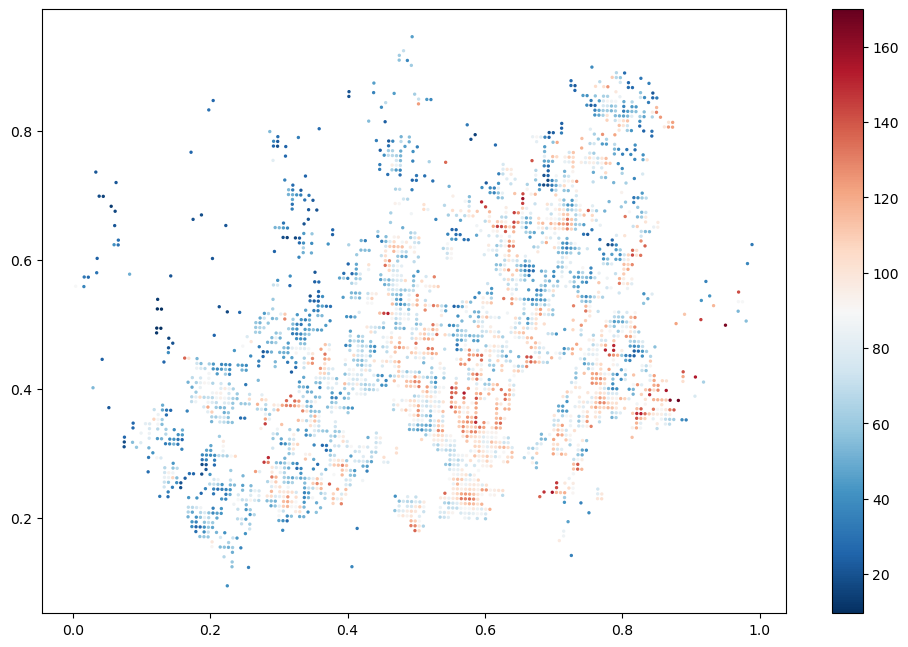

In [228]:
# plot predicted train dataset
val_pred = interp_GPR.predict(points_train_norm)
plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(points_train_norm[:, 0], points_train_norm[:, 1], s=2, c=val_pred, cmap="RdBu_r")
plt.colorbar()
plt.show()

In [210]:
# calculate RMSE(root mean square error)
rmse = metrics.mean_squared_error(val_train, val_pred, squared=False)
print(rmse)

29.393404322028573


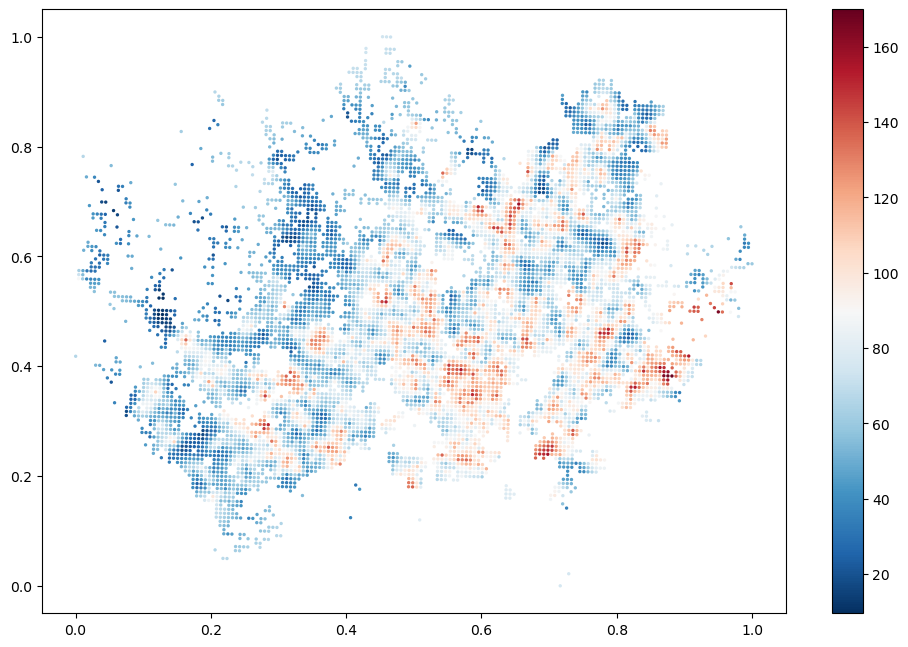

In [229]:
# plot inter dataset
val_inter_pred = interp_GPR.predict(points_inter_norm)
plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(points_inter_norm[:, 0], points_inter_norm[:, 1], s=2, c=val_inter_pred, cmap="RdBu_r")
plt.colorbar()
plt.show()